In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

dane = pd.read_csv('../../clustering_R3.csv')
dane.head()

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814


### Standaryzacja danych

In [2]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(dane.iloc[:,[0,1,2]])
dane = pd.DataFrame(std_scale.transform(dane.iloc[:,[0,1,2]]), columns=["X1", "X2", "X3"])

dane.head()

,X1,X2,X3
0,-0.762807,1.024554,-0.909772
1,-0.819582,1.125110,-0.566853
2,-0.733687,1.029615,-1.004782
3,-0.777429,1.236698,-0.995176
4,-0.781982,1.203537,-0.396348


Przedstawienie danych przed podziałem na klastry

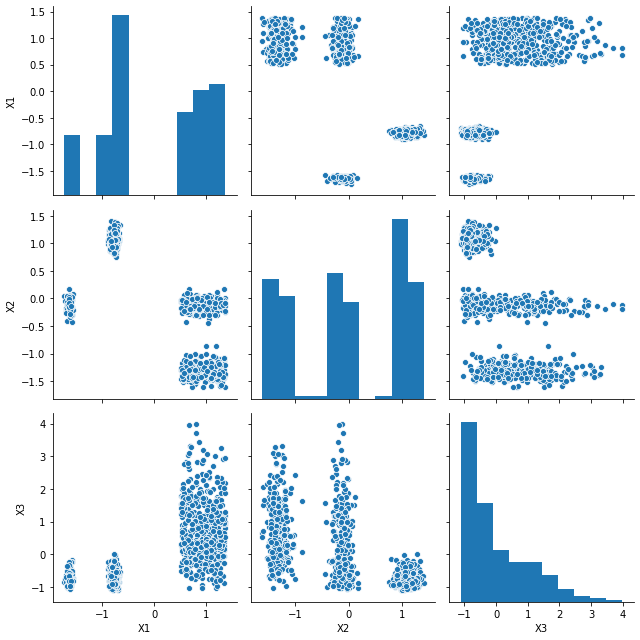

In [3]:
import seaborn as sns

sns.pairplot(dane, height=3)
plt.tight_layout()

## K-means
Do wybrania optymalnej liczby klastrów użyjemy współczynnika Silhouette (im więcej tym lepiej) i Daviesa-Bouldina (im mniej tym lepiej).

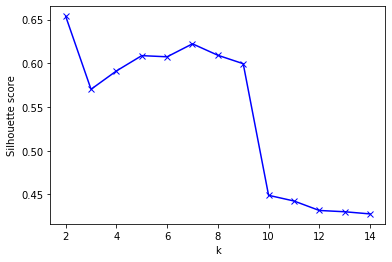

In [4]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    
    
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

cluster_num_seq = range(2, 15)
silhouette_vec = count_clustering_scores(dane, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

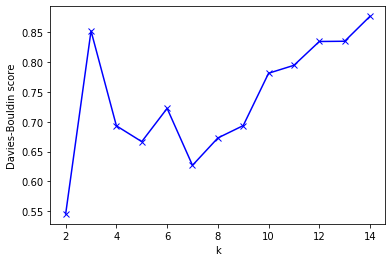

In [5]:
davies_bouldin_vec = count_clustering_scores(dane, cluster_num_seq, KMeans, davies_bouldin_score)
plt.plot(cluster_num_seq, davies_bouldin_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.show()

Obie metryki są zgodne - optymalna liczba klastrów dla algorytmu k-means to 2.
### Graficzne przedstawienie k-means przy k=2

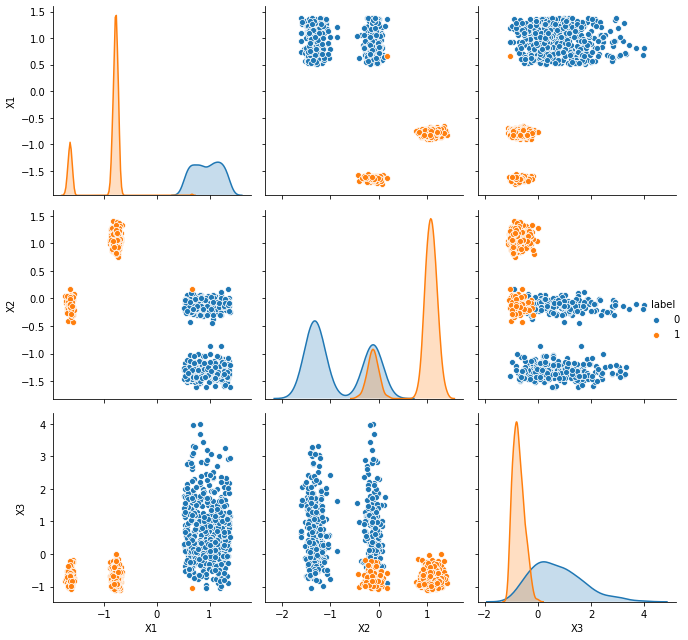

In [6]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(dane)
dane['label'] = kmeans.predict(dane)

sns.pairplot(dane, height=3, hue='label')
plt.tight_layout()

Podział wydaje się dość sensowny, ale mógłby być lepszy (większa liczba klastrów).
## DBSCAN
Ten algorytm sam dobiera liczbę klastrów, po naszej stronie jest dobranie epsilonu.

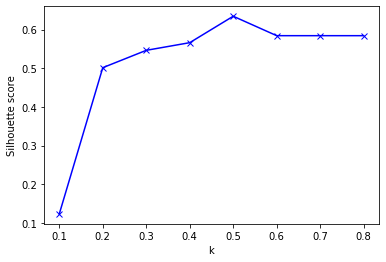

In [7]:
dane.drop(columns=["label"])
from sklearn import cluster
import numpy as np

def count_dbscan_scores(X, eps, score_fun):
    if isinstance(eps, float):
        eps_iter = [eps]
    else:
        eps_iter = eps
        
    scores = []    
    for k in eps_iter:
        model_instance = cluster.DBSCAN(eps=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(eps, float):
        return scores[0]
    else:
        return scores

eps_seq = np.arange(0.1, 0.9, 0.1)
silhouette_vec = count_dbscan_scores(dane, eps_seq, silhouette_score)
plt.plot(eps_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

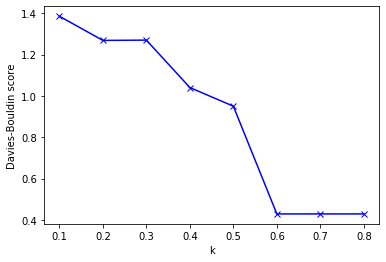

In [8]:
davies_bouldin_vec = count_dbscan_scores(dane, eps_seq, davies_bouldin_score)
plt.plot(eps_seq, davies_bouldin_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.show()

Według metryki Silhouette najlepszą wartością epsilona jest defaultowa (0.5), jednak Davies-Buildin score raczej proponuje 0.6-0.8. Użyjemy zatem 0.5 i 0.6 i porównamy wyniki.

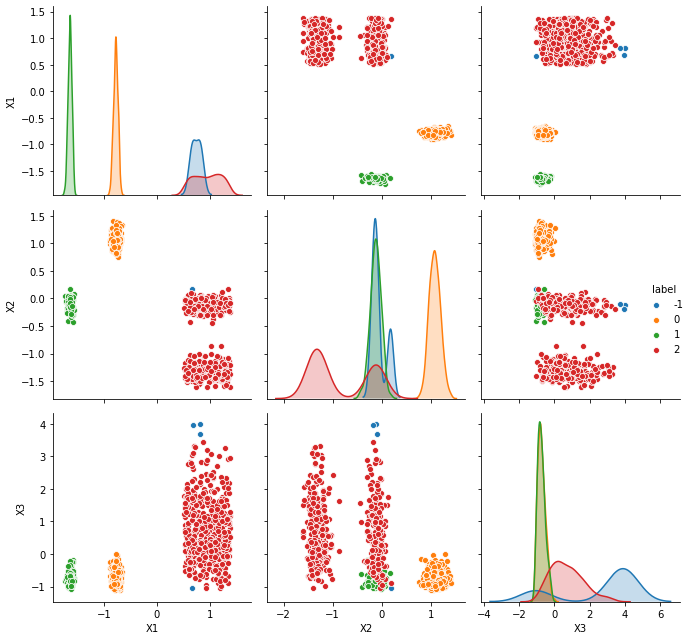

In [9]:
dbscan = cluster.DBSCAN()
dane['label'] = dbscan.fit_predict(dane)

sns.pairplot(dane, height=3, hue='label')
plt.tight_layout()

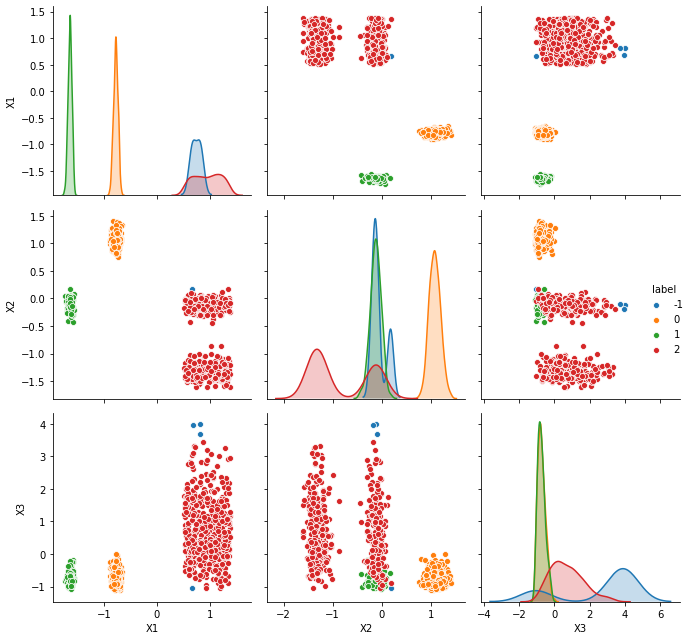

In [10]:
dane.drop(columns=["label"])
dbscan = cluster.DBSCAN(eps=0.6)
dane['label'] = dbscan.fit_predict(dane)

sns.pairplot(dane, height=3, hue='label')
plt.tight_layout()

W obu przypadkach mamy 4 klastry, więc możemy założyć, że to jest optymalna liczba klastrów (DBSCAN sam dobiera liczbę klastrów, dla tego podziału metryki dawały lepsze wyniki od pozostałych, więc możemy założyć, że liczba klastrów jest ok).

### Porównanie metryk dla obu modeli
* silhouette - definiuje, jak dobrze punkt pasuje do klastra, w którym się znajduje, z wyników brana jest średnia, niestety premiuje okrągłe klastry (więcej - lepiej)
* Davies-Bouldin - miara podobieństwa klastra z najbardziej podobnym klastrem, podobieństwo liczone na podstawie odległości między klastrami i wewnątrz klastrów (mniej - lepiej)

In [11]:
dane.drop(columns=["label"])

df = pd.DataFrame()
df.loc["KMEANS", "Silhouette"] = count_clustering_scores(X=dane, cluster_num=2, model=KMeans, score_fun=silhouette_score)
df.loc["KMEANS", "Davies-Bouldin"] = count_clustering_scores(X=dane, cluster_num=2, model=KMeans, score_fun=davies_bouldin_score)
# Użyjemy domyślnego eps=0.5, nie bez powodu jest domyślny :)
df.loc["DBSCAN", "Silhouette"] = count_dbscan_scores(X=dane, eps=0.5, score_fun=silhouette_score)
df.loc["DBSCAN", "Davies-Bouldin"] = count_dbscan_scores(X=dane, eps=0.5, score_fun=davies_bouldin_score)

In [12]:
df

,Silhouette,Davies-Bouldin
KMEANS,0.688268,0.494043
DBSCAN,0.699648,0.636402


Wartości metryki Silhouette dla obu metod klasteryzacji okazały się podobne, dość znaczną różnicę widać za to w indeksie Daviesa-Bouldina. Według tej metryki metoda KMeans okazała się lepsza (mnie osobiście wydawało się na podstawie wizualizacji, że DBSCAN poradził sobie lepiej, ale taki wynik jest prawdopodobnie związany ze specyfiką Daviesa-Bouldina - klastry w naszym przykładzie leżą bardzo blisko siebie).

# Oświadczenie
Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu _Wstęp do Uczenia Maszynowego_ została wykonana przeze mnie samodzielnie.

Anna Urbala
298847